# Analiza "Drug consumption (quantified) Data Set"

Joanna Paliwoda <br>
Filip Hałoń

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr, chi2_contingency, ttest_ind, mannwhitneyu
%matplotlib inline  

In [2]:
all_columns = [
    'ID', 
    'Age', 
    'Gender', 
    'Education', 
    'Country',
    'Ethnicity',
    'Neuroticism',
    'Extraversion',
    'Openness to experience',
    'Agreeableness',
    'Conscientiousness',
    'Impulsiveness',
    'Sensation seeking',
    'Alcohol consumption',
    'Amphetamines consumption',
    'Amyl nitrite consumption',
    'Benzodiazepine consumption',
    'Caffeine consumption',
    'Cannabis consumption',
    'Chocolate consumption',
    'Cocaine consumption',
    'Crack consumption',
    'Ecstasy consumption',
    'Heroin consumption',
    'Ketamine consumption',
    'Legal highs consumption',
    'Lysergic acid diethylamide consumption',
    'Methadone consumption',
    'Magic mushrooms consumption',
    'Nicotine consumption',
    'Fictitious drug Semeron consumption',
    'Volatile substance abuse consumption'
]

demographic_columns = [
    'Age', 
    'Gender', 
    'Education', 
    'Country',
    'Ethnicity',
]

personality_columns = [
    'Neuroticism',
    'Extraversion',
    'Openness to experience',
    'Agreeableness',
    'Conscientiousness',
    'Impulsiveness',
    'Sensation seeking'
]

drugs_columns = [
    'Alcohol consumption',
    'Amphetamines consumption',
    'Amyl nitrite consumption',
    'Benzodiazepine consumption',
    'Caffeine consumption',
    'Cannabis consumption',
    'Chocolate consumption',
    'Cocaine consumption',
    'Crack consumption',
    'Ecstasy consumption',
    'Heroin consumption',
    'Ketamine consumption',
    'Legal highs consumption',
    'Lysergic acid diethylamide consumption',
    'Methadone consumption',
    'Magic mushrooms consumption',
    'Nicotine consumption',
    'Fictitious drug Semeron consumption',
    'Volatile substance abuse consumption'
]


def value_counts_percentage(dataset, column):
    ''' value.counts() method extended by displaying percentage '''
    a = dataset[column].value_counts()
    b = dataset[column].value_counts(normalize=True) * 100
    return pd.concat([a,b.round(2)], axis=1, keys=['N', '%'])
    

def heatmap_corr(dataset, method='spearman', ready=False, mask=True, nominal=False):
    ''' extended sns.heatmap() method. 
    dataset - can be 'pure' data (without calculated correlations) or a DataFrame with already calcuateg correlations (in that case attribute 'ready' should be set to True);
    method - mainly pearson or spearman; nominal correlations should be calculated externally and be delivered with attribute ready=True; 
    mask - if dataset is NOT a cross-valued DataFrame of one type, mask should be set to False;
    nominal - for nominal data correlations values are in range (0, 1) instead of (-1, -1). nominal=True should be folowed by ready=True 
    '''
    if not ready:
        corr = dataset.corr(method=method)
    elif ready:
        corr = dataset
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    vmax = corr.max().max()
    if nominal:
        center = 0.5
        cmap=None
    elif not nominal:
        center = 0
    if mask:
        mask = np.zeros_like(corr, dtype=np.bool)
        mask[np.triu_indices_from(mask)] = True
        vmax = corr.replace(1, -2).max().max()
    elif not mask:
        mask=None
    f, ax = plt.subplots(figsize=(20,9))
    return sns.heatmap(corr, cmap=cmap, mask=mask, vmax=vmax, center=center, annot=True, square=True, linewidths=0.5, cbar_kws={'shrink': 0.5})
    
    
def calculate_r(df1, df2, method='spearman', p=0.05, pvalues=True):
    ''' Returns correlation matrix extended by statistical significance index. Used for non-nominal data.
    df1, df2 - DataFrames of data to correlate;
    method - mainly pearson and spearman;
    p - significance level;
    pvalues - if set to False, only correlation values will be returned in DataFrame (without '**' marks for significant observations)
    '''
    data_corr_table = pd.DataFrame()
    data_pvalues = pd.DataFrame()
    for x in df1.columns:
        for y in df2.columns:
            if method == 'pearson':
                corr = pearsonr(df1[x], df2[y])
            elif method == 'spearman':
                corr = spearmanr(df1[x], df2[y])
            else:
                raise ValueError('Unknown method')
            if pvalues:
                data_corr_table.loc[x,y] = '{} {}'.format(round(corr[0], 3), '**' if round(corr[1], 3) < p else '')
            elif not pvalues:
                data_corr_table.loc[x,y] = round(corr[0], 3)
            data_pvalues.loc[x,y] = round(corr[1], 3)
    return data_corr_table, data_pvalues


def cramers_v(crosstab):
    ''' Returns Cramer's V correlation coefficient (and statistic significance) for data delivered as a crosstable. Used for nominal data.
    '''
    chi2 = chi2_contingency(crosstab)[0]
    n = crosstab.sum().sum()
    phi2 = chi2/n
    r,k = crosstab.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return round(np.sqrt(phi2corr / min((kcorr-1), (rcorr-1))), 3), '**' if chi2_contingency(crosstab)[1] < 0.05 else ''


def nominal_corrs(dataset, col_1_names, col_2_names, pvalues=True):
    ''' Returns Cramer's V coefficients matrix for the whole dataset.
    col_1_names, col_2_names - lists of names of columns to correlate. Function creates crosstables for every columns' combination and returns a matrix with single Cramer's V coefficients of every combination;
    pvalues - if set to False, only correlation values will be returned in DataFrame (without '**' marks for significant observations)
    '''
    corr_table = pd.DataFrame()
    for i in range(len(col_1_names)):
        for j in range(len(col_2_names)):
            crosstab = pd.crosstab(dataset[col_1_names[i]], [dataset[col_2_names[j]]])
            if pvalues:
                v = ' '.join([str(i) for i in cramers_v(crosstab)])
            elif not pvalues:
                v = cramers_v(crosstab)[0]
            corr_table.loc[i, j] = v
    corr_table.index = col_1_names
    corr_table.columns = col_2_names
    return corr_table


def diff_test(dataset, sample_attr, diff_attr, sample_attr_type='ordered', diff_attr_type='ordered'):
    ''' Difference significance test on dataset. Returns a text summary.
    sample_attr - column which will be divided into two samples with median value;
    diff_attr - attribute, which value will be checked in two sample groups;
    diff_attr_type - determines type of data which medians will be compared (ordered, interval)
    '''
    sample_attr_central = dataset[sample_attr].median() if sample_attr_type=='ordered' else dataset[sample_attr].mean()
    group_1 = dataset[dataset[sample_attr] > sample_attr_central]
    group_2 = dataset[dataset[sample_attr] <= sample_attr_central]
    
    group_1_diff_attr_central = group_1[diff_attr].median() if diff_attr_type=='ordered' else group_1[diff_attr].mean()
    group_2_diff_attr_central = group_2[diff_attr].median() if diff_attr_type=='ordered' else group_2[diff_attr].mean()
    
    if diff_attr_type == 'ordered':
        diff_sign, p = mannwhitneyu(group_1[diff_attr], group_2[diff_attr])
    elif diff_attr_type == 'interval':
        diff_sign, p = ttest_ind(group_1[diff_attr], group_2[diff_attr])
    are = 'are' if p < 0.05 else 'are not'
    sample_central = 'median' if sample_attr_type=='ordered' else 'mean'
    diff_central = 'median' if diff_attr_type=='ordered' else 'mean'
    return f"First group: {sample_attr} above {sample_central} value {round(sample_attr_central, 3)}\n Second group: {sample_attr} equal or below {sample_central} value {round(sample_attr_central, 3)} \n First group {diff_attr} {diff_central}: {round(group_1_diff_attr_central, 3)} \n Second group {diff_attr} {diff_central}: {round(group_2_diff_attr_central, 3)} \n Difference significance for samples: {round(diff_sign, 3)} with p-value: {round(p, 3)} \n Samples {are} statistically different."

# Informacje na temat zbioru danych

1. 1885 rekordów, 32 kolumny, w tym:

* 5 demograficznych: Wiek, Płeć, Państwo, Poziom edukacji i Pochodzenie etniczne. Wiek i Poziom edukacji – porządkowe, reszta – nominalne

* 7 czynników osobowości: neurotyczność, ekstrawersja, otwartość na doświadczenie, ugodowość, sumienność, impulsywność, szukanie doznań

* 18 używek i częstotliwość ich zażywania

* 1 fikcyjny lek Semeron, służący do weryfikacji wiarygodności odpowiedzi (znalazło się 8 osób, głównie do 25 r.ż. Ich rekordy zostały wykluczone z dalszej analizy)

2. Wszystkie dane, w tym demograficzne, są liczbowe i dyskretne. Poza Płcią, Państwem i Pochodzeniem etnicznym wszystkie zmienne są porządkowe

In [3]:
data = pd.read_csv('drug_consumption.data', header=None, names=all_columns)
# data.to_csv('drug consumption.csv')
sns.set(rc={'figure.figsize':(10,5)})
sns.set_style("whitegrid")
data.shape

(1885, 32)

### Converting nominal values into ordered data

In [4]:
for i in drugs_columns:
    data[i] = data[i].map({'CL0': 0, 'CL1': 1, 'CL2': 2, 'CL3': 3, 'CL4': 4, 'CL5': 5, 'CL6': 6})

### Responders who claimed they took Semeron

Semeron was a fictitious drug which was introduced to identify over-claimers

In [5]:
semerons = data[data['Fictitious drug Semeron consumption'] != 0]
semerons

,ID,Age,Gender,Education,Country,Ethnicity,Neuroticism,Extraversion,Openness to experience,Agreeableness,...,Ecstasy consumption,Heroin consumption,Ketamine consumption,Legal highs consumption,Lysergic acid diethylamide consumption,Methadone consumption,Magic mushrooms consumption,Nicotine consumption,Fictitious drug Semeron consumption,Volatile substance abuse consumption
727,730,-0.07854,0.48246,-1.73790,-0.09765,-0.31685,-0.58016,0.32197,0.14143,-0.60633,...,2,2,2,0,4,2,6,6,2,2
817,821,-0.95197,-0.48246,-0.61113,-0.09765,-0.50212,-0.67825,1.74091,0.72330,0.13136,...,3,0,0,0,5,0,5,4,3,0
1516,1520,-0.95197,-0.48246,-0.61113,-0.57009,-0.31685,-0.24649,-0.80615,-1.27553,-1.34289,...,1,2,1,2,1,2,4,2,3,1
1533,1537,-0.95197,0.48246,-0.61113,-0.57009,0.11440,-0.46725,0.80523,0.29338,2.03972,...,4,0,4,3,2,0,3,4,4,3
1698,1702,0.49788,0.48246,0.45468,-0.57009,-0.31685,1.98437,-0.80615,2.15324,0.76096,...,2,0,2,2,2,0,2,6,2,0
1769,1773,-0.95197,-0.48246,-1.22751,-0.57009,-0.22166,-0.34799,1.28610,1.06238,-0.01729,...,3,0,4,3,6,3,3,3,1,3
1806,1810,-0.95197,0.48246,-1.43719,-0.57009,-0.31685,1.23461,1.11406,1.06238,-1.47955,...,4,2,1,4,1,0,1,6,1,2
1823,1827,-0.95197,0.48246,0.45468,-0.57009,-0.31685,0.22393,-0.30033,0.88309,1.28610,...,0,0,0,2,3,0,3,5,2,0


### Removing overclaimers


In [6]:
data = data[data['Fictitious drug Semeron consumption'] == 0]
drugs_columns.remove('Fictitious drug Semeron consumption')
data.shape

(1877, 32)

# Omówienie danych demograficznych

Interaktywna mapa

https://public.tableau.com/profile/joanna3872#!/vizhome/Drugconsumption/Drugconsumptionanalysis

# Demographic overview

Original demographic data is categorical but quantified, so for analysis purposes we retrieve it to more clear form

In [7]:
demo_data = data[demographic_columns].copy()

In [8]:
age = ['18-24' if w<=-0.9 else '25-34' if w>=-0.5 and w<0 else '35-44' if w>0 and w<1 else '45-54' if w>1 and w<1.5 else '55-64' if w>1.5 and w<2 else '65+' for w in demo_data['Age']]

gender = ['Female' if w>0 else "Male" for w in demo_data['Gender']]

#education_level = [0 if w<-2 else 1 if w>-2 and w<-1.5 else 2 if w>-1.5 and w<-1.4 else 3 if w>-1.4 and w<-1 else 4 if w>-1 and w<-0.5 else 5 if w >-0.5 and w<0 else 6 if w>0 and w<0.5 else 7 if w>0.5 and w<1.5 else 8 for w in demo_data['Education']]
education = ['Left school before 16 years' if w<-2 else 'Left school at 16 years' if w>-2 and w<-1.5 else 'Left school at 17 years' if w>-1.5 and w<-1.4 else 'Left school at 18 years' if w>-1.4 and w<-1 else 'Some college or university, no certificate or degree' if w>-1 and w<-0.5 else 'Professional certificate/ diploma' if w >-0.5 and w<0 else 'University degree' if w>0 and w<0.5 else 'Masters degree' if w>0.5 and w<1.5 else 'Doctorate degree' for w in demo_data['Education']]

country = ['USA' if w<-0.5 else 'New Zealand' if w>-0.5 and w<-0.4 else 'Other' if w>-0.4 and w<-0.2 else 'Australia' if w>-0.2 and w<0 else 'Ireland' if w>0 and w<0.23 else 'Canada' if w>0.23 and w<0.9 else 'UK' for w in demo_data['Country']]

ethnicity = ['Black' if w<-1 else 'Asian' if w>-1 and w<-0.4 else 'White' if w>-0.4 and w<-0.25 else 'Mixed-White/Black' if w>=-0.25 and w<0.11 else 'Mixed-White/Asian' if w>0.12 and w<1 else 'Mixed-Black/Asian' if w>1.9 else 'Other' for w in demo_data['Ethnicity']]


demo_data['Age'] = age
demo_data['Gender'] = gender
demo_data['Education'] = education
#demo_data['Education level'] = education_level
demo_data['Country'] = country
demo_data['Ethnicity'] = ethnicity

1. Płeć rozkłada się mniej więcej po równo

## Gender

In [9]:
value_counts_percentage(demo_data, 'Gender')

,N,%
Male,940,50.08
Female,937,49.92


2. Wiek: podany w przedziałach co ok. 10 lat.
<br>
<ul>
    <li>18-24 to największa grupa, ok. 1/3 wszystkich badanych.</li>
    <li>25-34 to ¼ badanych, a 35-54 to kolejna 1/3 badanych.</li>
    <li>Pozostałe ok 5% to osoby powyżej 55 r.ż.</li>
</ul>

## Age

In [10]:
value_counts_percentage(demo_data, 'Age')

,N,%
18-24,637,33.94
25-34,480,25.57
35-44,355,18.91
45-54,294,15.66
55-64,93,4.95
65+,18,0.96


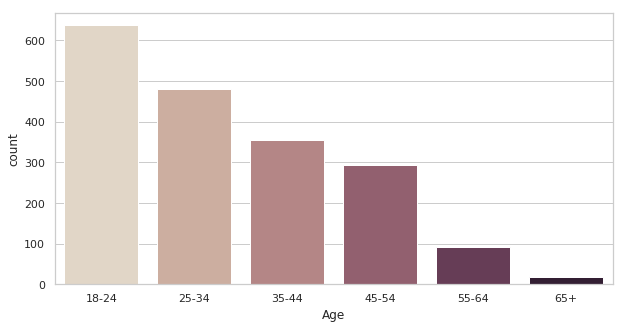

In [11]:
sns.countplot(x='Age', palette='ch:.25', data=demo_data.sort_values(by=['Age']))

3. Poziom edukacji: zdecydowanie przeważają osoby wykształcone, od poziomu collegu w górę (ok 85% wszystkich). Pozostałe osoby ukończyły edukację do 18 r.ż.

## Education

In [12]:
value_counts_percentage(demo_data, 'Education')

,N,%
"Some college or university, no certificate or degree",503,26.80
University degree,478,25.47
Masters degree,283,15.08
Professional certificate/ diploma,270,14.38
Left school at 18 years,99,5.27
Left school at 16 years,98,5.22
Doctorate degree,89,4.74
Left school at 17 years,29,1.55
Left school before 16 years,28,1.49


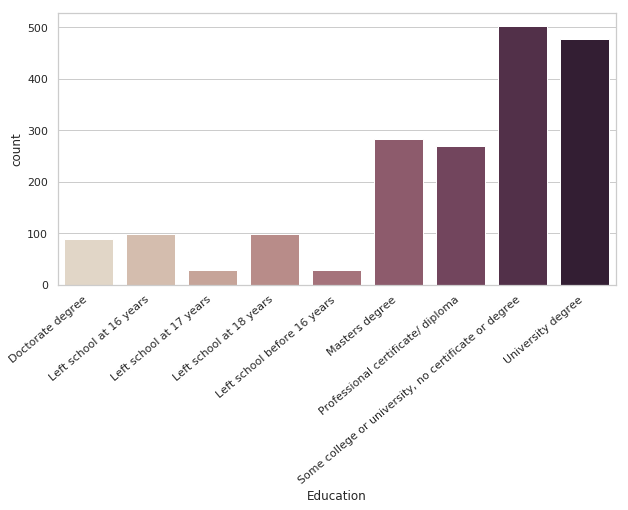

In [13]:
edu_plot = sns.countplot(x='Education', palette='ch:.25', data=demo_data.sort_values(by=['Education']))
edu_plot.set_xticklabels(edu_plot.get_xticklabels(), rotation=40, ha="right")
edu_plot

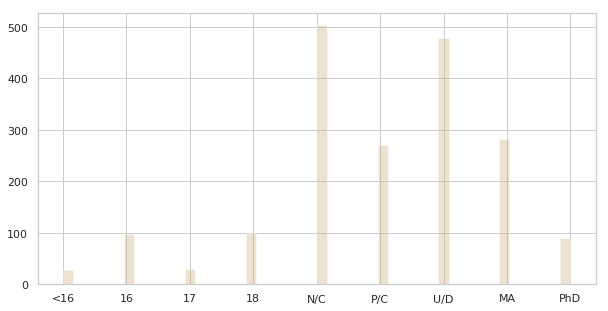

In [14]:
education_int=[0 if w<-2 else 1 if w>-2 and w<-1.5 else 2 if w>-1.5 and w<-1.4 else 3 if w>-1.4 and w<-1 else 4 if w>-1 and w<-0.5 else 5 if w >-0.5 and w<0 else 6 if w>0 and w<0.5 else 7 if w>0.5 and w<1.5 else 8 for w in data['Education']]
educationplot=sns.distplot(education_int, bins = 50, kde=False, color='tan')
educationplot.set(xticklabels=["<16", 
                         "16", 
                         "17", 
                         "18", 
                         "N/C", 
                         "P/C", 
                         "U/D", 
                         "MA", 
                         "PhD"])
educationplot.set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8])

4. Pochodzenie etniczne: ponad 90% osób badanych to osoby rasy białej

## Ethnicity

In [15]:
value_counts_percentage(demo_data, 'Ethnicity')

,N,%
White,1715,91.37
Other,62,3.30
Black,33,1.76
Asian,25,1.33
Mixed-White/Asian,20,1.07
Mixed-White/Black,19,1.01
Mixed-Black/Asian,3,0.16


5. Państwo: wszystkie państwa są oficjalnie anglojęzyczne. Ponad 50% pochodzi z UK, prawie 1/3 z USA

## Country

In [16]:
value_counts_percentage(demo_data, 'Country')

,N,%
UK,1044,55.62
USA,551,29.36
Other,118,6.29
Canada,87,4.64
Australia,52,2.77
Ireland,20,1.07
New Zealand,5,0.27


6. Płeć – Wiek: w grupie 18-24 przeważają mężczyźni. W pozostałych grupach, wraz ze wzrostem wieku, rozkład płci się stopniowo wyrównuje

## Age – Gender distribution

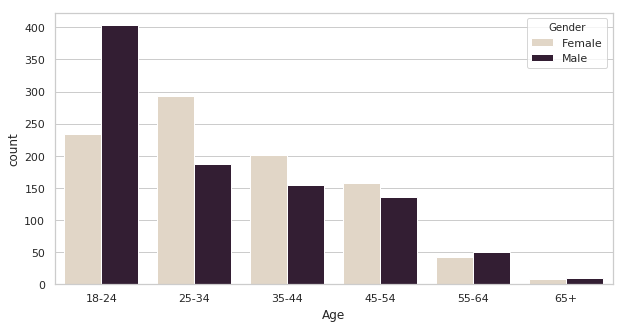

In [17]:
sns.countplot(x='Age', hue='Gender', palette='ch:.25', data=demo_data.sort_values(by=['Age']))

7. Państwo – Płeć: w UK przebadano więcej kobiet, (stosunek mniej więcej 3:2) a w USA więcej mężczyzn (ok 7:4). W pozostałych – mniej więcej po równo

## Country – Gender distribution

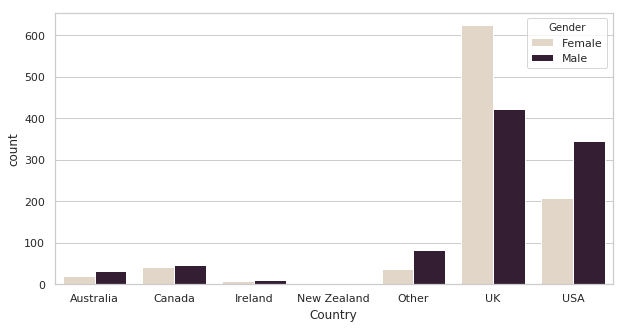

In [18]:
sns.countplot(x='Country', hue='Gender', palette='ch:.25', data=demo_data.sort_values(by=['Country']))

8. Wiek – Płeć – Państwo: W Nowej Zelandii nie przebadano osób powyżej 35 r.ż. W Irlandii nie przebadano osób powyżej 55 r.ż. W Australii nie przebadano żadnych osób powyżej 65 r.ż.     

## Age – Gender – Country cross table

In [19]:
pd.crosstab(demo_data['Age'], [demo_data['Gender'], demo_data['Country']])

Gender     Female                                                Male         \
Country Australia Canada Ireland New Zealand Other   UK USA Australia Canada   
Age                                                                            
18-24           1      7       3           0    12  112  99        20     25   
25-34          10      9       2           1    13  200  58         5      8   
35-44           4      8       3           0     7  150  29         3      7   
45-54           5      7       1           0     4  127  14         3      4   
55-64           0      7       0           0     0   29   7         1      1   
65+             0      3       0           0     0    5   0         0      1   

Gender                                       
Country Ireland New Zealand Other   UK  USA  
Age                                          
18-24         5           2    39   91  221  
25-34         3           2    26   80   63  
35-44         0           0    10  108   26  
45-54         3           0     5   99   22  
55-64         0           0     2   36   10  
65+           0           0     0    7    2

## Education – Gender – Ethnicity cross table

In [20]:
demo_data.pivot_table(index='Education', columns=['Gender', 'Ethnicity'], aggfunc='size', fill_value=0)

Gender                                             Female        \
Ethnicity                                           Asian Black   
Education                                                         
Doctorate degree                                        1     0   
Left school at 16 years                                 0     0   
Left school at 17 years                                 0     0   
Left school at 18 years                                 0     0   
Left school before 16 years                             0     0   
Masters degree                                          4     6   
Professional certificate/ diploma                       0     3   
Some college or university, no certificate or d...      3     2   
University degree                                       7     6   

Gender                                                                \
Ethnicity                                          Mixed-Black/Asian   
Education                                                              
Doctorate degree                                                   0   
Left school at 16 years                                            0   
Left school at 17 years                                            0   
Left school at 18 years                                            0   
Left school before 16 years                                        0   
Masters degree                                                     0   
Professional certificate/ diploma                                  0   
Some college or university, no certificate or d...                 1   
University degree                                                  1   

Gender                                                                \
Ethnicity                                          Mixed-White/Asian   
Education                                                              
Doctorate degree                                                   1   
Left school at 16 years                                            0   
Left school at 17 years                                            0   
Left school at 18 years                                            0   
Left school before 16 years                                        0   
Masters degree                                                     3   
Professional certificate/ diploma                                  1   
Some college or university, no certificate or d...                 2   
University degree                                                  4   

Gender                                                                      \
Ethnicity                                          Mixed-White/Black Other   
Education                                                                    
Doctorate degree                                                   2     1   
Left school at 16 years                                            0     2   
Left school at 17 years                                            1     0   
Left school at 18 years                                            0     2   
Left school before 16 years                                        0     0   
Masters degree                                                     5     5   
Professional certificate/ diploma                                  0     2   
Some college or university, no certificate or d...                 1     8   
University degree                                                  2     8   

Gender                                                    Male        \
Ethnicity                                          White Asian Black   
Education                                                              
Doctorate degree                                      52     1     0   
Left school at 16 years                               40     0     0   
Left school at 17 years                               12     0     0   
Left school at 18 years                               35     0     1   
Left school before 16 ye

## Country – Gender – Ethnicity cross table

In [21]:
pd.crosstab(demo_data['Country'], [demo_data['Gender'], demo_data['Ethnicity']])

Gender      Female                                            \
Ethnicity    Asian Black Mixed-Black/Asian Mixed-White/Asian   
Country                                                        
Australia        0     0                 0                 0   
Canada           0     0                 0                 2   
Ireland          0     0                 0                 0   
New Zealand      0     0                 0                 0   
Other            1     1                 0                 0   
UK              11    14                 0                 6   
USA              3     2                 2                 3   

Gender                                     Male                          \
Ethnicity   Mixed-White/Black Other White Asian Black Mixed-Black/Asian   
Country                                                                   
Australia                   0     0    20     0     0                 0   
Canada                      0     1    38     0     0                 0   
Ireland                     0     0     9     0     0                 0   
New Zealand                 0     0     1     0     0                 0   
Other                       2     2    30     1     0                 1   
UK                          9    12   571     9    11                 0   
USA                         0    13   184     0     5                 0   

Gender                                                       
Ethnicity   Mixed-White/Asian Mixed-White/Black Other White  
Country                                                      
Australia                   0                 0     0    32  
Canada                      0                 2     2    42  
Ireland                     0                 0     0    11  
New Zealand                 0                 0     0     4  
Other                       0                 1     5    74  
UK                          2                 1     4   394  
USA                         7                 4    23   305

## Correlation between demographic info (with Cramer's V)

** values that are statistically significant (p < 0.05)

Variables should be dychotomized!

In [22]:
corr_table_demo = nominal_corrs(demo_data, demographic_columns, demographic_columns)
corr_table_demo

,Age,Gender,Education,Country,Ethnicity
Age,1.0 **,0.196 **,0.229 **,0.173 **,0.014
Gender,0.196 **,0.999 **,0.235 **,0.219 **,0.0
Education,0.229 **,0.235 **,1.0 **,0.2 **,0.0
Country,0.173 **,0.219 **,0.2 **,1.0 **,0.053 **
Ethnicity,0.014,0.0,0.0,0.053 **,1.0 **


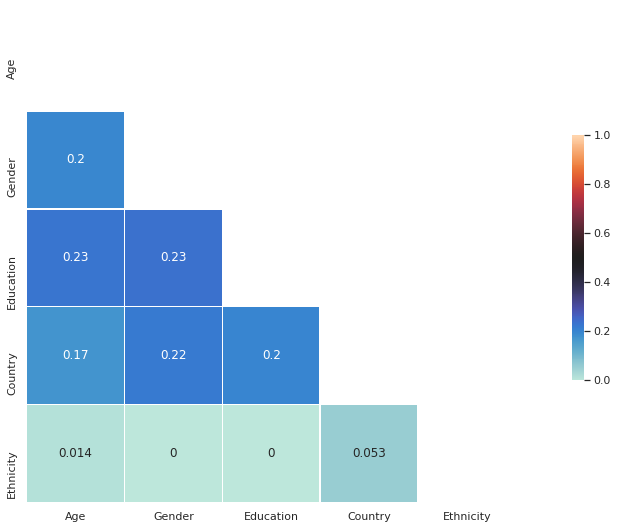

In [23]:
corr_table_demo_no_pvalues = nominal_corrs(demo_data, demographic_columns, demographic_columns, pvalues=False)
heatmap_corr(corr_table_demo_no_pvalues, nominal=True, ready=True)

# Omówienie danych na temat używek

# Drug consumption

System kodowania zastosowany w zbiorze danych

CL0 - Never Used

CL1 - Used over a Decade Ago

CL2 - Used in Last Decade

CL3 - Used in Last Year

CL4 - Used in Last Month

CL5 - Used in Last Week

CL6 - Used in Last Day


In [24]:
drug_data = data[drugs_columns].copy()

## All drugs consumption frequency overview

In [25]:
d1 = drug_data['Alcohol consumption'].value_counts()
d2 = drug_data['Amphetamines consumption'].value_counts()
d3 = drug_data['Amyl nitrite consumption'].value_counts()
d4 = drug_data['Benzodiazepine consumption'].value_counts()
d5 = drug_data['Caffeine consumption'].value_counts()
d6 = drug_data['Cannabis consumption'].value_counts()
d7 = drug_data['Chocolate consumption'].value_counts()
d8 = drug_data['Cocaine consumption'].value_counts()
d9 = drug_data['Crack consumption'].value_counts()
d10 = drug_data['Ecstasy consumption'].value_counts()
d11 = drug_data['Heroin consumption'].value_counts()
d12 = drug_data['Ketamine consumption'].value_counts()
d13 = drug_data['Legal highs consumption'].value_counts()
d14 = drug_data['Lysergic acid diethylamide consumption'].value_counts()
d15 = drug_data['Methadone consumption'].value_counts()
d16 = drug_data['Magic mushrooms consumption'].value_counts()
d17 = drug_data['Nicotine consumption'].value_counts()
d18 = drug_data['Volatile substance abuse consumption'].value_counts()

drug_table = pd.concat([d1, d2, d3, d4, d5, d6, d7, d8, d9, d10, d11, d12, d13, d14, d15, d16, d17, d18], axis=1, 
          keys=['Alcohol', 'Amphetamines', 'Amyl nitrite', 'Benzodiazepine', 'Caffeine', 'Cannabis', 'Chocolate', 
                'Cocaine', 'Crack', 'Ecstasy', 'Heroin', 'Ketamine', 'Legal highs', 'LSD', 
                'Methadone', 'Magic mushrooms', 'Nicotine', 'VSA'], sort=True)
drug_table.T.fillna(0).astype(np.int64)

,0,1,2,3,4,5,6
Alcohol,33,34,68,197,284,758,503
Amphetamines,973,230,241,196,75,61,101
Amyl nitrite,1299,210,236,91,24,14,3
Benzodiazepine,999,116,230,234,119,84,95
Caffeine,27,10,24,59,106,271,1380
Cannabis,413,207,266,210,138,185,458
Chocolate,32,2,10,53,295,680,805
Cocaine,1036,160,267,257,98,40,19
Crack,1622,67,109,59,9,9,2
Ecstasy,1020,112,232,275,154,63,21


Używki, których większość badanych nigdy nie próbowała

## Drugs almost never taken (DL0>1300)

In [26]:
drug_table1 = pd.concat([d3, d9, d11, d12, d15, d18], axis=1, 
          keys=['Amyl nitrite', 'Crack', 'Heroin', 'Ketamine', 
                'Methadone', 'VSA'], sort=True)
drug_table1.T.fillna(0).astype(np.int64)

,0,1,2,3,4,5,6
Amyl nitrite,1299,210,236,91,24,14,3
Crack,1622,67,109,59,9,9,2
Heroin,1600,68,91,65,24,16,13
Ketamine,1488,43,140,129,40,33,4
Methadone,1424,39,95,148,50,48,73
VSA,1452,199,133,59,13,14,7


Używki wypróbowane przez sporą część badanych (ale nie większość z nich)

## Drugs taken rarely (1300>DL0>500)


In [27]:
drug_table2 = pd.concat([d2, d4, d8, d10, d13, d14, d16], axis=1, 
          keys=['Amphetamines', 'Benzodiazepine', 
                'Cocaine', 'Ecstasy', 'Legal highs', 'LSD', 
                'Magic mushrooms'], sort=True)
drug_table2.T.fillna(0).astype(np.int64)

,0,1,2,3,4,5,6
Amphetamines,973,230,241,196,75,61,101
Benzodiazepine,999,116,230,234,119,84,95
Cocaine,1036,160,267,257,98,40,19
Ecstasy,1020,112,232,275,154,63,21
Legal highs,1092,29,195,321,109,64,67
LSD,1069,257,175,213,96,55,12
Magic mushrooms,982,208,259,272,114,39,3


Amfetamina, Azotyn amylu, Benzodiazepiny, Kokaina, Ekstazy, Heroina, Ketamina, Dopalacze, LSD, Metadon, Grzyby halucynogenne, Substancje lotne – zdecydowana większość osób nie próbowała ich nigdy lub bardzo dawno temu.

Intuicje: ludzie albo nie zażywają tych substancji w ogóle (np. bo się boją/nie chcą), albo spróbują raz kiedyś i potem już do tego nie wracają.

Używki wypróbowane przez większość badanych

## Drugs taken frequently (DL0<500)

In [28]:
drug_table3 = pd.concat([d1, d5, d6, d7, d17], axis=1, 
          keys=['Alcohol', 'Caffeine', 'Cannabis', 'Chocolate', 'Nicotine'], sort=True)
drug_table3.T.fillna(0).astype(np.int64)

,0,1,2,3,4,5,6
Alcohol,33,34,68,197,284,758,503
Caffeine,27,10,24,59,106,271,1380
Cannabis,413,207,266,210,138,185,458
Chocolate,32,2,10,53,295,680,805
Nicotine,428,193,203,184,106,156,607


* Alkohol, kofeina, czekolada i nikotyna to używki, które są zażywane raczej bardzo często i mało kto ich nigdy nie próbował.

* Najpowszechniej stosowaną używką wśród badanych jest kofeina - większość badanych spożywa ją regularnie. Czekolada plasuje się na drugim miejscu.

Intuicje: zarówno kofeina, jak i czekolada, są powszechnie dostępne oraz najbezpieczniejsze w stosowaniu, co tłumaczy ich popularność. Mimo to niewielka grupa badanych nigdy spożywała kofeiny albo czekolady

* Marihuana – rozkłada się mniej więcej równo; tyle samo osób brało ją ostatnio co nie próbowało jej nigdy.

Intuicje: to odzwierciedla położenie marihuany między narkotykami a „zwykłymi” używkami

Korealcje między stosowaniem używek

## Spearman's correlations among drug consumption

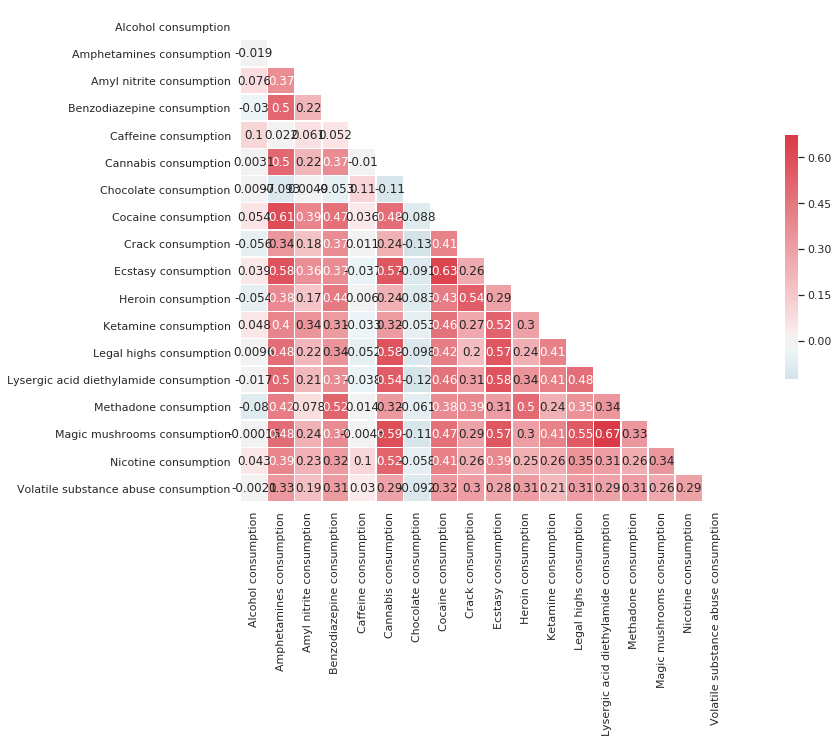

In [29]:
heatmap_corr(drug_data, method='spearman')

* Spożywanie alkoholu, kofeiny i czekolady koreluje nieznacznie lub wcale ze stosowaniem innych używek.

* Pozostałe korelacje to co najwyżej korelacje umiarkowane. Między zażywaniem używek nie ma korelacji silnych.

Najsilniejsze korelacje (istotne, tylko dodatnie - ujemnych brak): 
     
* LSD a grzyby halucynogenne (r = 0.67)
         
* Ekstazy a kokaina (r = 0.63)
         
* Kokaina a amfetamina (r = 0.61)
         
* Grzyby halucynogenne a marihuana (r = 0.59)
         
* Ekstazy a amfetamina (r = 0.58)
         
* Dopalacze a marihuana (r = 0.58)
         
* LSD a ekstazy (r = 0.58)
         
* Ekstazy a marihuana (r = 0.57)
         
* Grzyby halucynogenne a ekstazy (r = 0.57)
         
* Dopalacze a ekstazy (r = 0.57)
         
* Grzyby halucynogenne a dopalacze (r = 0.55)
         
* Heroina a Crack (r = 0.54)
         
* LSD a marihuana (r = 0.54)
         
* Metadon a benzodiazepiny (r = 0.52)
         
* Ketamina a ekstazy (r = 0.52)
         
* Nikotyna a marihuana (r = 0.52)
         
* LSD a amfetamina (r = 0.5)
         
* Benzodiazepiny a amfetamina (r = 0.5)
         
* Marihuana a benzodiazepiny (r = 0.5)
         
* Metadon a heroina (r = 0.5)


LSD a grzyby halucynogenne (r = 0.67)

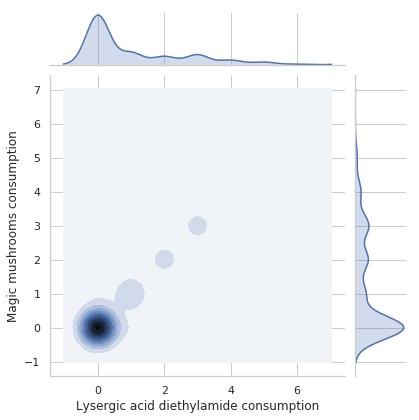

In [30]:
sns.jointplot(drug_data['Lysergic acid diethylamide consumption'], drug_data['Magic mushrooms consumption'], kind='kde')

Ekstazy a kokaina (r = 0.63)

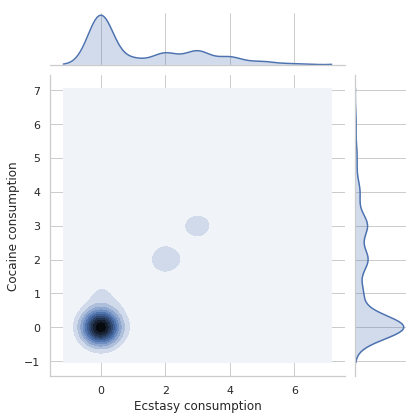

In [31]:
sns.jointplot(drug_data['Ecstasy consumption'], drug_data['Cocaine consumption'], kind='kde')

Kokaina a amfetamina (r = 0.61)

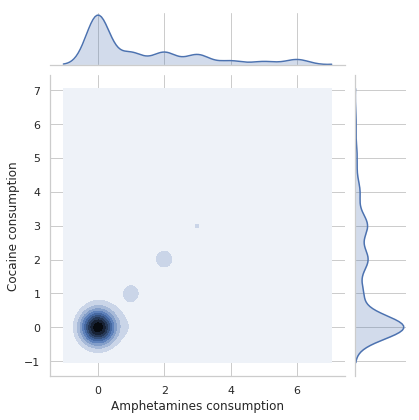

In [32]:
sns.jointplot(drug_data['Amphetamines consumption'], drug_data['Cocaine consumption'], kind='kde')

## Spearman's correlations among drug consumptions with calculated probability (p-value)

In [33]:
drug_data_corr_table, drug_data_pvalues = calculate_r(drug_data, drug_data, method='spearman')
drug_data_corr_table

,Alcohol consumption,Amphetamines consumption,Amyl nitrite consumption,Benzodiazepine consumption,Caffeine consumption,Cannabis consumption,Chocolate consumption,Cocaine consumption,Crack consumption,Ecstasy consumption,Heroin consumption,Ketamine consumption,Legal highs consumption,Lysergic acid diethylamide consumption,Methadone consumption,Magic mushrooms consumption,Nicotine consumption,Volatile substance abuse consumption
Alcohol consumption,1.0 **,-0.019,0.076 **,-0.03,0.103 **,0.003,0.01,0.054 **,-0.056 **,0.039,-0.054 **,0.048 **,0.01,-0.017,-0.08 **,-0.0,0.043,-0.002
Amphetamines consumption,-0.019,1.0 **,0.365 **,0.505 **,0.022,0.504 **,-0.093 **,0.606 **,0.338 **,0.579 **,0.382 **,0.402 **,0.481 **,0.499 **,0.422 **,0.484 **,0.395 **,0.327 **
Amyl nitrite consumption,0.076 **,0.365 **,1.0 **,0.219 **,0.061 **,0.217 **,0.005,0.395 **,0.178 **,0.359 **,0.169 **,0.344 **,0.216 **,0.208 **,0.078 **,0.236 **,0.228 **,0.188 **
Benzodiazepine consumption,-0.03,0.505 **,0.219 **,1.0 **,0.052 **,0.37 **,-0.053 **,0.467 **,0.372 **,0.373 **,0.437 **,0.314 **,0.345 **,0.37 **,0.515 **,0.374 **,0.318 **,0.314 **
Caffeine consumption,0.103 **,0.022,0.061 **,0.052 **,1.0 **,-0.01,0.109 **,0.036,0.011,-0.037,0.006,-0.033,-0.052 **,-0.038,0.014,-0.004,0.101 **,0.03
Cannabis consumption,0.003,0.504 **,0.217 **,0.37 **,-0.01,1.0 **,-0.108 **,0.477 **,0.24 **,0.566 **,0.239 **,0.319 **,0.578 **,0.542 **,0.322 **,0.593 **,0.515 **,0.29 **
Chocolate consumption,0.01,-0.093 **,0.005,-0.053 **,0.109 **,-0.108 **,1.0 **,-0.088 **,-0.126 **,-0.091 **,-0.083 **,-0.053 **,-0.098 **,-0.122 **,-0.061 **,-0.108 **,-0.058 **,-0.092 **
Cocaine consumption,0.054 **,0.606 **,0.395 **,0.467 **,0.036,0.477 **,-0.088 **,1.0 **,0.406 **,0.631 **,0.428 **,0.465 **,0.42 **,0.464 **,0.378 **,0.469 **,0.414 **,0.322 **
Crack consumption,-0.056 **,0.338 **,0.178 **,0.372 **,0.011,0.24 **,-0.126 **,0.406 **,1.0 **,0.26 **,0.539 **,0.269 **,0.199 **,0.308 **,0.391 **,0.293 **,0.256 **,0.305 **
Ecstasy consumption,0.039,0.579 **,0.359 **,0.373 **,-0.037,0.566 **,-0.091 **,0.631 **,0.26 **,1.0 **,0.29 **,0.523 **,0.57 **,0.581 **,0.313 **,0.565 **,0.392 **,0.282 **


# Omówienie danych osobowościowych

# Personality measurements

Sposób zakodowania danych osobowościowych

Personality measurements include NEO-FFI-R (neuroticism, extraversion, openness to experience, agreeableness, and conscientiousness), BIS-11 (impulsivity) and ImpSS (sensation seeking)

Neuroticism: levels 12 - 60

Extraversion: levels 16 - 59

Openess to experience: levels 24 - 60

Agreeableness: levels 12 - 60

Conscientiousness: levels 17 - 59


Rozkład danych osobowościowych

In [34]:
pers_data = data[personality_columns].copy()
pers_data.describe()

,Neuroticism,Extraversion,Openness to experience,Agreeableness,Conscientiousness,Impulsiveness,Sensation seeking
count,1877.000000,1877.000000,1877.000000,1877.000000,1877.000000,1877.000000,1877.000000
mean,-0.000551,-0.001951,-0.003224,-0.000657,-0.000394,0.005293,-0.007408
std,0.998442,0.997418,0.995691,0.996689,0.997657,0.954148,0.962074
min,-3.464360,-3.273930,-3.273930,-3.464360,-3.464360,-2.555240,-2.078480
25%,-0.678250,-0.695090,-0.717270,-0.606330,-0.652530,-0.711260,-0.525930
50%,0.042570,0.003320,-0.019280,-0.017290,-0.006650,-0.217120,0.079870
75%,0.629670,0.637790,0.723300,0.760960,0.584890,0.529750,0.765400
max,3.273930,3.273930,2.901610,3.464360,3.464360,2.901610,1.921730


Korelacje między cechami osobowościowymi metodą Spearmana

## Spearman's correlations among personality traits


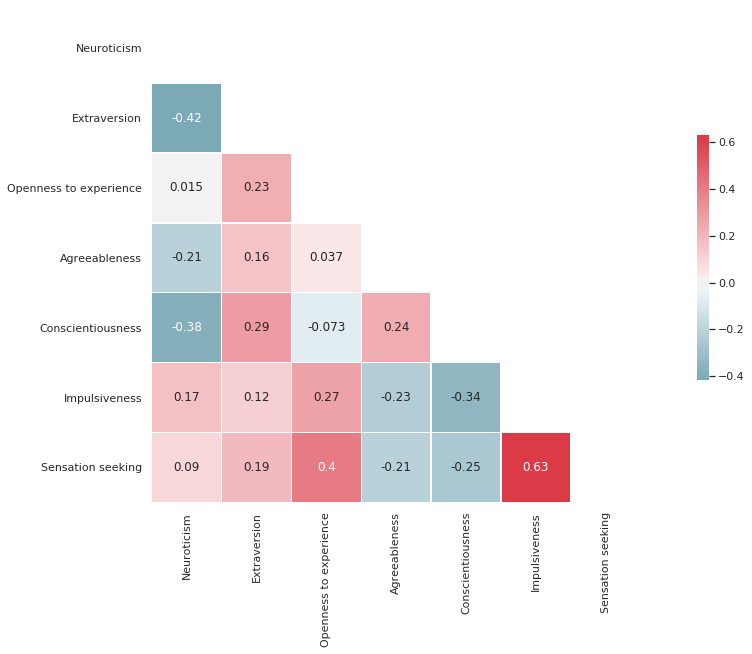

In [35]:
heatmap_corr(pers_data, method='spearman')

* nie ma korelacji między Otwartością na doświadczenie a Neurotycznością

* pozostałe korelacje to co najwyżej korelacje umiarkowane. Między czynnikami osobowości nie ma korelacji silnych

## Spearman's correlations among personality traits (with p-value)


Korelacje cech osobowościowych metodą Spearmana - tabela

In [36]:
pers_data_corr_table, pers_data_pvalues = calculate_r(pers_data, pers_data, method='spearman')
pers_data_corr_table

,Neuroticism,Extraversion,Openness to experience,Agreeableness,Conscientiousness,Impulsiveness,Sensation seeking
Neuroticism,1.0 **,-0.417 **,0.015,-0.206 **,-0.378 **,0.168 **,0.09 **
Extraversion,-0.417 **,1.0 **,0.226 **,0.162 **,0.29 **,0.119 **,0.19 **
Openness to experience,0.015,0.226 **,1.0 **,0.037,-0.073 **,0.27 **,0.405 **
Agreeableness,-0.206 **,0.162 **,0.037,1.0 **,0.237 **,-0.226 **,-0.208 **
Conscientiousness,-0.378 **,0.29 **,-0.073 **,0.237 **,1.0 **,-0.344 **,-0.254 **
Impulsiveness,0.168 **,0.119 **,0.27 **,-0.226 **,-0.344 **,1.0 **,0.628 **
Sensation seeking,0.09 **,0.19 **,0.405 **,-0.208 **,-0.254 **,0.628 **,1.0 **


Najsilniejsze korelacje (istotne, dodatnie):
     
* Szukanie doznań a Impulsywność (r = 0.63)
         
* Szukanie doznań a Otwartość na doświadczenie (r = 0.4)
     

Najsilniejsze korelacje (istotne, ujemne):
     
* Ekstrawersja a Neurotyczność (r = -0.42)
         
* Neurotyzm a Sumienność (r = -0.38)
         
* Sumienność a Impulsywność (r = -0.34)


## Relation between Sensation seeking and Impulsiveness

Korelacja między Poszukiwaniem doznań a Impulsywnością

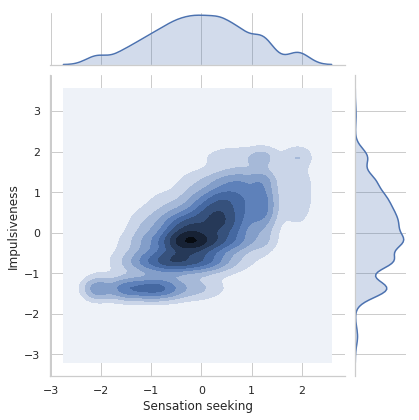

In [37]:
sns.jointplot(data['Sensation seeking'], data['Impulsiveness'], kind='kde')

Korelacja między Ekstrawersją na Neurotycznością

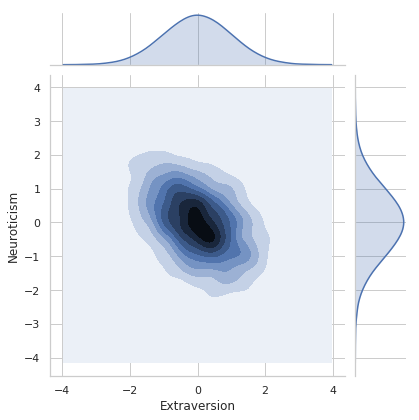

In [38]:
sns.jointplot(data['Extraversion'], data['Neuroticism'], kind='kde')

## Spearman's correlations among drug consumptions and personality traits (with p-value)

In [39]:
drug_pers_corr_table, drug_pers_pvalues = calculate_r(drug_data, pers_data, method='spearman')
drug_pers_corr_table

,Neuroticism,Extraversion,Openness to experience,Agreeableness,Conscientiousness,Impulsiveness,Sensation seeking
Alcohol consumption,0.0,0.084 **,0.032,-0.033,0.006,0.039,0.094 **
Amphetamines consumption,0.135 **,-0.042,0.253 **,-0.14 **,-0.253 **,0.294 **,0.365 **
Amyl nitrite consumption,0.04,0.04,0.065 **,-0.079 **,-0.121 **,0.13 **,0.189 **
Benzodiazepine consumption,0.266 **,-0.096 **,0.225 **,-0.164 **,-0.217 **,0.233 **,0.255 **
Caffeine consumption,0.022,0.013,-0.02,-0.008,0.006,0.014,-0.005
Cannabis consumption,0.11 **,-0.022,0.417 **,-0.155 **,-0.293 **,0.313 **,0.465 **
Chocolate consumption,0.025,0.028,-0.015,0.038,0.023,-0.015,-0.052 **
Cocaine consumption,0.144 **,0.006,0.205 **,-0.183 **,-0.221 **,0.264 **,0.34 **
Crack consumption,0.118 **,-0.052 **,0.126 **,-0.091 **,-0.13 **,0.19 **,0.197 **
Ecstasy consumption,0.087 **,0.056 **,0.311 **,-0.118 **,-0.249 **,0.272 **,0.405 **


Korelacje między zażywaniem używek a cechami osobowościowymi metodą Spearmana

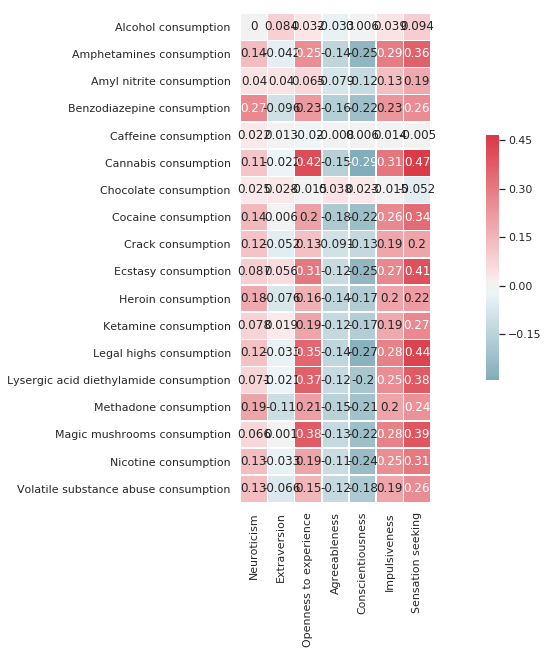

In [40]:
drug_pers_corr_table_no_pvalues, drug_pers_pvalues_no_pvalues = calculate_r(drug_data, pers_data, pvalues=False, method='spearman')
heatmap_corr(drug_pers_corr_table_no_pvalues, ready=True, mask=False)

* Alkohol, kofeina i czekolada korelują bardzo słabo albo w ogóle z czynnikami osobowości. Częstotliwość ich zażywania nie zależy od osobowości.

* Ekstrawersja koreluje bardzo słabo lub w ogóle z zażywaniem jakichkolwiek używek.

* Sumienność koreluje słabo ujemnie ze wszystkimi używkami (r > -0.3), najsilniej z tego z Marihuaną, Dopalaczami, Amfetaminą, Ekstazy, Nikotyną.

* Pozostałe korelacje to co najwyżej korelacje umiarkowane. Między czynnikami osobowości a zażywaniem używek nie ma korelacji silnych.

Najsilniejsze korelacje (istotne, dodatnie, bo ujemnych takich nie ma):
     
* Szukanie doznań a marihuana (r = 0.47)
         
* Szukanie doznań a dopalacze (r = 0.44)
         
* Otwartość na doświadczenie a Marihuana (r = 0.42)
         
* Szukanie doznań a ekstazy (r = 0.41)
         
* Szukanie doznań a grzyby halucynogenne (r = 0.39)
         
* Szukanie doznań a LSD (r = 0.38)
         
* Otwartość na doświadczenie a grzyby halucynogenne (r = 0.38)
         
* Otwartość na doświadczenie a LSD (r = 0.37)
         
* Szukanie doznań a amfetamina (r = 0.36)
         
* Otwartość na doświadczenie a dopalacze (r = 0.35)

## Nominal correlations among demographic info and drug consumption

Korelacje nominalne między danymi demograficznymi a zażywaniem używek współczynnikiem V Cramera

In [41]:
corr_table = nominal_corrs(data, demographic_columns, drugs_columns)
corr_table

,Alcohol consumption,Amphetamines consumption,Amyl nitrite consumption,Benzodiazepine consumption,Caffeine consumption,Cannabis consumption,Chocolate consumption,Cocaine consumption,Crack consumption,Ecstasy consumption,Heroin consumption,Ketamine consumption,Legal highs consumption,Lysergic acid diethylamide consumption,Methadone consumption,Magic mushrooms consumption,Nicotine consumption,Volatile substance abuse consumption
Age,0.083 **,0.196 **,0.151 **,0.144 **,0.093 **,0.24 **,0.087 **,0.173 **,0.079 **,0.203 **,0.11 **,0.131 **,0.215 **,0.233 **,0.117 **,0.221 **,0.186 **,0.156 **
Gender,0.041,0.249 **,0.157 **,0.156 **,0.0,0.309 **,0.088 **,0.178 **,0.151 **,0.241 **,0.131 **,0.189 **,0.327 **,0.286 **,0.188 **,0.278 **,0.193 **,0.139 **
Education,0.079 **,0.122 **,0.045 **,0.093 **,0.033,0.166 **,0.043 **,0.068 **,0.082 **,0.125 **,0.068 **,0.061 **,0.144 **,0.133 **,0.106 **,0.14 **,0.131 **,0.098 **
Country,0.07 **,0.184 **,0.112 **,0.171 **,0.044 **,0.229 **,0.063 **,0.123 **,0.117 **,0.146 **,0.136 **,0.061 **,0.183 **,0.213 **,0.189 **,0.203 **,0.136 **,0.151 **
Ethnicity,0.148 **,0.047 **,0.035,0.046 **,0.072 **,0.088 **,0.023,0.047 **,0.052 **,0.029,0.0,0.0,0.049 **,0.062 **,0.022,0.056 **,0.063 **,0.074 **


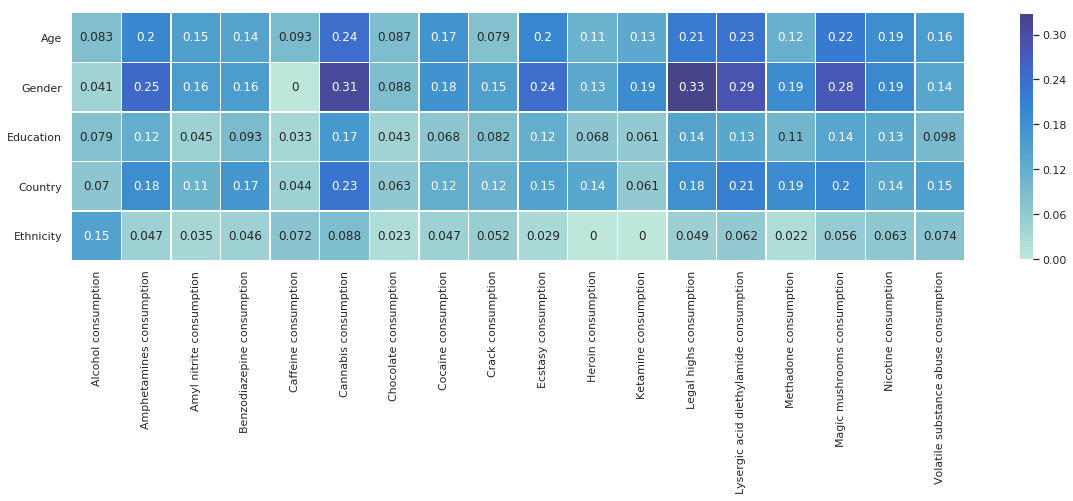

In [42]:
corr_table_no_pvalues = nominal_corrs(data, demographic_columns, drugs_columns, pvalues=False)
heatmap_corr(corr_table_no_pvalues, ready=True, mask=False, nominal=True)

* nie ma korelacji silnych ani nawet umiarkowanych - wszystkie są słabe (r < 0.33). Najsilniejsze z tych słabych są korelacje Płci, potem Wieku, a najsłabsze (żadne) Pochodzenia etnicznego.     

Najsilniejsze korelacje (istotne; w obu przypadkach mężczyźni brali używki częściej):
     
* Płeć a dopalacze (r = 0.33)
         
* Płeć a marihuana (r = 0.31)

In [43]:
gender_data_female = data[demo_data['Gender']=='Female']
gender_data_male = data[demo_data['Gender']=='Male']
print(f"Female cannabis consumption median: {gender_data_female['Cannabis consumption'].median()}")
print(f"Male cannabis consumption median: {gender_data_male['Cannabis consumption'].median()}")
print(f"Female legal highs consumption median: {gender_data_female['Legal highs consumption'].median()}")
print(f"Male legal highs consumption median: {gender_data_male['Legal highs consumption'].median()}")

Female cannabis consumption median: 2.0
Male cannabis consumption median: 4.0
Female legal highs consumption median: 0.0
Male legal highs consumption median: 2.0


## Nominal correlations among demographic info and personality traits

# Korelacje nominalne między danymi demograficznymi a cechami osobowościowymi współczynnikiem V Cramera

In [44]:
corr_table_demo_psycho = nominal_corrs(data, demographic_columns, personality_columns)
corr_table_demo_psycho

,Neuroticism,Extraversion,Openness to experience,Agreeableness,Conscientiousness,Impulsiveness,Sensation seeking
Age,0.033,0.0,0.139 **,0.0,0.095 **,0.103 **,0.159 **
Gender,0.089,0.063,0.139 **,0.22 **,0.173 **,0.19 **,0.261 **
Education,0.054,0.032,0.094 **,0.0,0.112 **,0.072 **,0.096 **
Country,0.047,0.086 **,0.141 **,0.036,0.105 **,0.098 **,0.144 **
Ethnicity,0.0,0.0,0.04,0.0,0.0,0.045 **,0.046 **


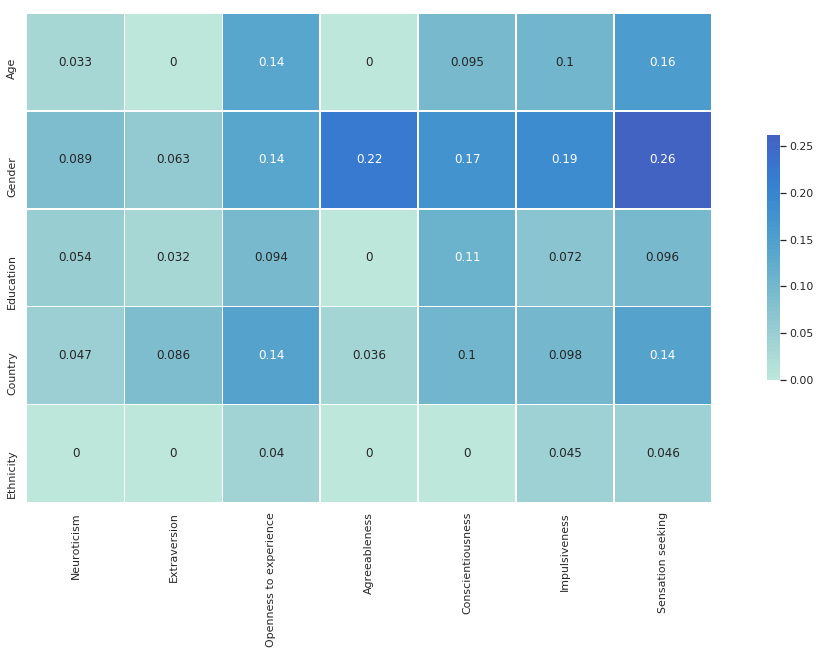

In [45]:
corr_table_demo_psycho_no_pvalues = nominal_corrs(data, demographic_columns, personality_columns, pvalues=False)
heatmap_corr(corr_table_demo_psycho_no_pvalues, ready=True, nominal=True, mask=False)

Nie ma korelacji silnych ani nawet umiarkowanych, wszystkie są słabe (r < 0.26). Najsilniejsze z tych słabych są korelacje Płci, a najsłabsze (żadne) Pochodzenia etnicznego.    

In [46]:
print(f"Female Agreeableness median: {gender_data_female['Agreeableness'].median()}")
print(f"Male Agreeableness median: {gender_data_male['Agreeableness'].median()}")
print(f"Female Sensation seeking median: {gender_data_female['Sensation seeking'].median()}")
print(f"Male Sensation seeking median: {gender_data_male['Sensation seeking'].median()}")

Female Agreeableness median: 0.28783000000000003
Male Agreeableness median: -0.30172
Female Sensation seeking median: -0.21575
Male Sensation seeking median: 0.40148


In [47]:
personality_melted=pd.melt(data.loc[:, [*personality_columns]])

idseries=[]
for i in range(7):
  for j in data['ID']:
    idseries.append(j)
    
to_plots=pd.DataFrame(idseries).join(personality_melted)
to_plots.columns=['ID', 'variable', 'value']
to_plots=to_plots.merge(data.loc[:, ['ID', *demographic_columns]], on='ID')

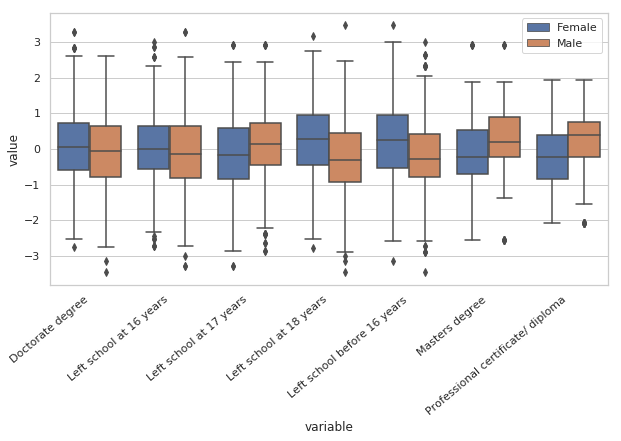

In [48]:
personality_plot = sns.boxplot(hue = ['Female' if w>0 else "Male" for w in to_plots['Gender']], 
            x='variable', y='value', data=to_plots)
personality_plot.set_xticklabels(edu_plot.get_xticklabels(), rotation=40, ha="right")
personality_plot

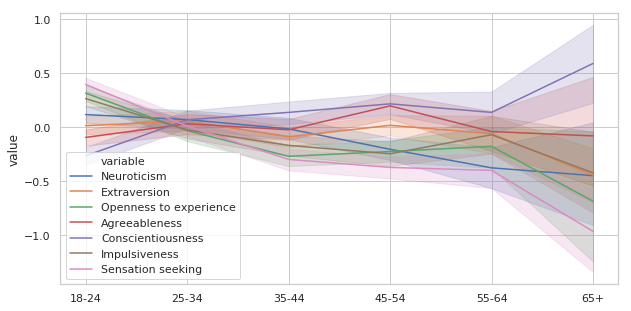

In [49]:
sns.lineplot(x = ['18-24' if w<=-0.9 else '25-34' if w>=-0.5 and w<0 else '35-44' if w>0 and w<1 else '45-54' if w>1 and w<1.5 else '55-64' if w>1.5 and w<2 else '65+' for w in to_plots['Age']],
             hue='variable', y='value', data=to_plots)

[[Text(0, 0, ''),
  Text(0, 0, '<16'),
  Text(0, 0, '16'),
  Text(0, 0, '17'),
  Text(0, 0, '18'),
  Text(0, 0, 'N/C'),
  Text(0, 0, 'P/C'),
  Text(0, 0, 'U/D'),
  Text(0, 0, 'MA'),
  Text(0, 0, 'PhD')]]

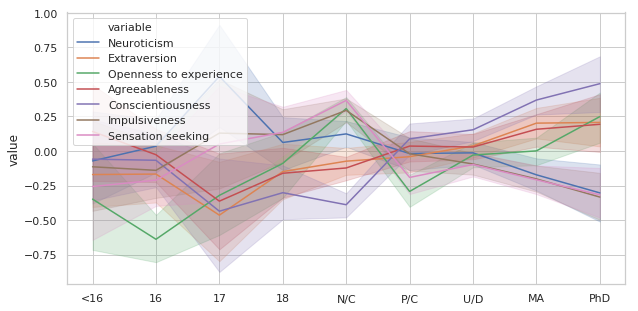

In [50]:
sns.lineplot(x = [1 if w<-2 else 2 if w>-2 and w<-1.5 else 3 if w>-1.5 and w<-1.4 else 4 if w>-1.4 and w<-1 else 5 if w>-1 and w<-0.5 else 6 if w >-0.5 and w<0 else 7 if w>0 and w<0.5 else 8 if w>0.5 and w<1.5 else 9 for w in to_plots['Education']],
             hue='variable', y='value', data=to_plots).set(xticklabels=["", "<16", "16", "17", "18", "N/C", "P/C", "U/D", "MA", "PhD"])

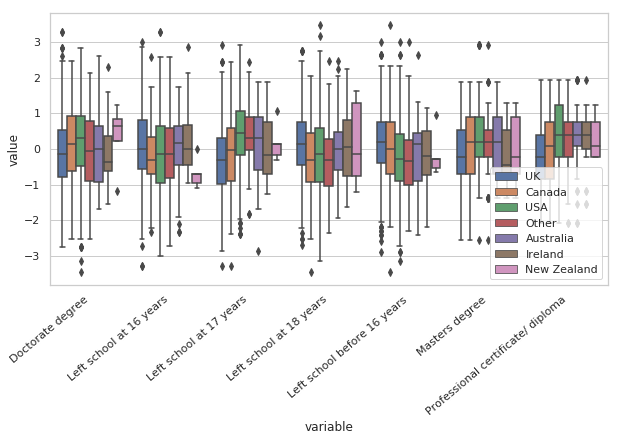

In [51]:
pers_plot = sns.boxplot(hue = ['USA' if w<-0.5 else 'New Zealand' if w>-0.5 and w<-0.4 else 'Other' if w>-0.4 and w<-0.2 else 'Australia' if w>-0.2 and w<0 else 'Ireland' if w>0 and w<0.23 else 'Canada' if w>0.23 and w<0.9 else 'UK' for w in to_plots['Country']],
            x='variable', y='value', data=to_plots) 
pers_plot.set_xticklabels(edu_plot.get_xticklabels(), rotation=40, ha="right")
pers_plot

## Difference significance tests

# Testy istotności różnic

In [52]:
diff_data = data.copy()
value_diff = diff_test(diff_data, 'Education', 'Cannabis consumption', sample_attr_type='ordered', diff_attr_type='ordered')
print(value_diff)

First group: Education above median value -0.059
 Second group: Education equal or below median value -0.059 
 First group Cannabis consumption median: 2.0 
 Second group Cannabis consumption median: 4.0 
 Difference significance for samples: 298583.5 with p-value: 0.0 
 Samples are statistically different.


In [53]:
value_diff = diff_test(diff_data, 'Sensation seeking', 'Cannabis consumption', sample_attr_type='ordered', diff_attr_type='ordered')
print(value_diff)

First group: Sensation seeking above median value 0.08
 Second group: Sensation seeking equal or below median value 0.08 
 First group Cannabis consumption median: 5.0 
 Second group Cannabis consumption median: 2.0 
 Difference significance for samples: 233444.0 with p-value: 0.0 
 Samples are statistically different.


In [54]:
value_diff = diff_test(diff_data, 'Education', 'Sensation seeking', diff_attr_type='ordered')
print(value_diff)

First group: Education above median value -0.059
 Second group: Education equal or below median value -0.059 
 First group Sensation seeking median: -0.216 
 Second group Sensation seeking median: 0.08 
 Difference significance for samples: 357713.5 with p-value: 0.0 
 Samples are statistically different.


In [55]:
value_diff = diff_test(diff_data, 'Age', 'Conscientiousness', diff_attr_type='ordered')
print(value_diff)

First group: Age above median value -0.079
 Second group: Age equal or below median value -0.079 
 First group Conscientiousness median: 0.26 
 Second group Conscientiousness median: -0.143 
 Difference significance for samples: 346840.0 with p-value: 0.0 
 Samples are statistically different.


In [56]:
value_diff = diff_test(diff_data, 'Gender', 'Caffeine consumption', diff_attr_type='ordered')
print(value_diff)

First group: Gender above median value -0.482
 Second group: Gender equal or below median value -0.482 
 First group Caffeine consumption median: 6.0 
 Second group Caffeine consumption median: 6.0 
 Difference significance for samples: 438337.5 with p-value: 0.411 
 Samples are not statistically different.
